In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

D:\Users\adria\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv("LBMA-SILVER.csv")
data = data[::-1].reset_index()
data = data.loc[0:175,['Date','USD']]
data

,Date,USD
0,2021-07-01,26.260
1,2021-07-02,26.170
2,2021-07-05,26.545
3,2021-07-06,26.610
4,2021-07-07,26.385
...,...,...
171,2022-03-03,25.310
172,2022-03-04,25.150
173,2022-03-07,25.740
174,2022-03-08,26.120


## Prepare the Data

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['USD'].values.reshape(-1,1))

prediction_days = 76

X_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Build the Model

In [18]:
units = 40

model = Sequential()

model.add(LSTM(units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units))
model.add(Dropout(0.2))

model.compile(optimizer = 'adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 4s 47ms/step - loss: 0.1893
Epoch 2/100
4/4 [==============================] - 0s 47ms/step - loss: 0.1680
Epoch 3/100
4/4 [==============================] - 0s 47ms/step - loss: 0.1280
Epoch 4/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0958
Epoch 5/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0881
Epoch 6/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0824
Epoch 7/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0778
Epoch 8/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0721
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0694
Epoch 10/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0692
Epoch 11/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0713
Epoch 12/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0694
Epoch 13/100
4/4 [==============================]

## Test the Model Accuracy on Existing Data

In [19]:
test = pd.read_csv("LBMA-SILVER.csv")
test = test[::-1].reset_index()
test = test.loc[175:,['Date','USD']]

actual_prices = test['USD'].values

total_dataset = pd.concat((data['USD'], test['USD']), axis = 0)

model_inputs=total_dataset[len(total_dataset)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

## Make Prediction on Test Data

In [20]:
X_test = []

for x in range (prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x-prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


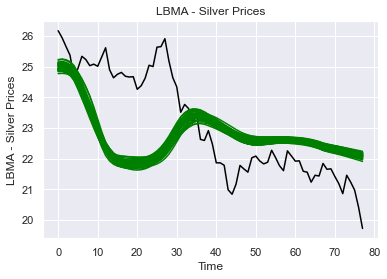

In [21]:
plt.plot(actual_prices, color = "black", label="Actual LBMA - Silver Prices")
plt.plot(predicted_prices, color="green", label="Predicted LBMA - Silver Prices")
plt.title("LBMA - Silver Prices")
plt.xlabel('Time')
plt.ylabel('LBMA - Silver Prices')
plt.show()

In [17]:
predicted_prices

array([[23.353188, 23.186747, 23.620316, ..., 23.219984, 23.386501,
        23.39938 ],
       [23.373335, 23.190084, 23.646816, ..., 23.222261, 23.407248,
        23.418139],
       [23.391907, 23.193148, 23.671692, ..., 23.224133, 23.427488,
        23.436184],
       ...,
       [22.807188, 22.934477, 22.952251, ..., 23.046751, 22.85248 ,
        22.802076],
       [22.794424, 22.926228, 22.938416, ..., 23.039917, 22.840332,
        22.787434],
       [22.778875, 22.916393, 22.921556, ..., 23.032112, 22.82611 ,
        22.77009 ]], dtype=float32)